In [1]:
from torchvision import datasets # MNIST datasets
from torchvision.transforms import ToTensor # transform PIL image to torch.Tensor
from torch import nn # neural network library
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader # mini-batch loader

import matplotlib.pyplot as plt # print image

In [2]:
# training set
train_ds = datasets.MNIST('./data', train=True, download=True, transform=ToTensor())
# test set
test_ds = datasets.MNIST('./data', train=False, download=True, transform=ToTensor())

print(f"train {len(train_ds)} test {len(test_ds)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 424kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.88MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

train 60000 test 10000


In [3]:
# the first training sample
x, y = train_ds[0]
print("input type", type(x))
print("input size", x.shape)
print("output type", type(y))
print("target", y)

input type <class 'torch.Tensor'>
input size torch.Size([1, 28, 28])
output type <class 'int'>
target 5


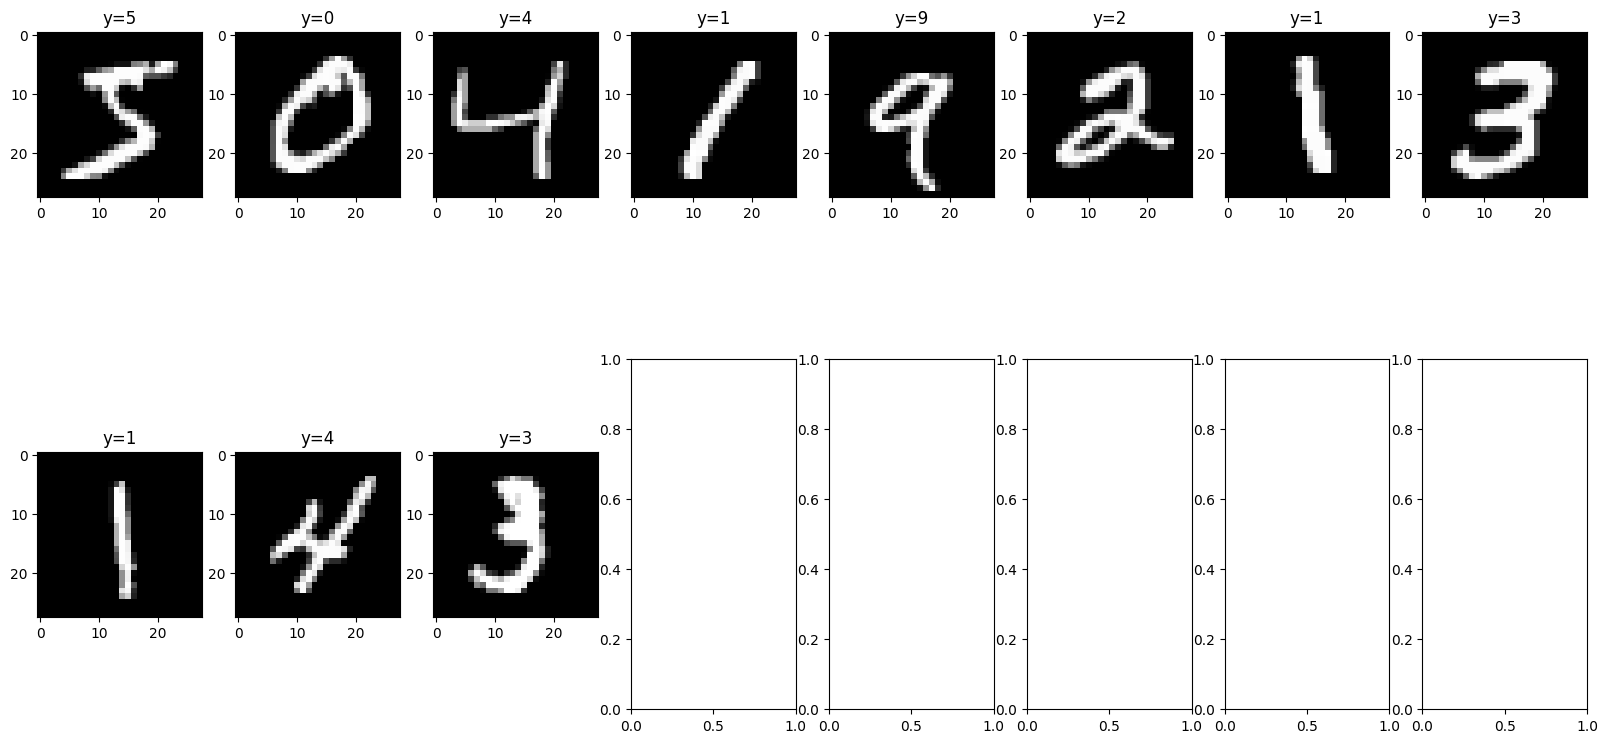

In [4]:
# plot a grid of samples with targets
def plot_grid(ds, n):
  ncols = 8
  nrows = n // ncols + 1
  plt.subplots(nrows, ncols, figsize=(20, 10))
  for i, (x, y) in enumerate(ds):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(x[0], cmap="gray")
    plt.title(f'y={y:01d}')
    if i >= n:
      break

plot_grid(train_ds, 10)

#**Multi-layer Perception (MLP)**

In [5]:
# define a multi-layer perceptrons
class MLP(nn.Module):
    def __init__(self, batch_size):
        super().__init__()

        # first layer 784 --> 100, relu activation
        self.fc1 = nn.Linear(28*28, 100, bias=False)
        self.relu1 = nn.ReLU()
        # second layer 100 --> 50, relu activation
        self.fc2 = nn.Linear(100, 50, bias=False)
        # Dropout layer + Batchnorm
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm = nn.BatchNorm1d(50)
        self.relu2 = nn.ReLU()

        # output layer 50 --> 10 class, linear activation
        self.fc3 = nn.Linear(50, 10, bias=False)
        #self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = x.view(batch_size, 28*28) # change (batchsize, 1, 28, 28) into (batchsize, 28*28) to apply linear fc1
        # first layer
        out = self.fc1(x)
        out = self.relu1(out)
        # second layer
        out = self.fc2(out)

        # dropout and batchnorm
        out = self.dropout(out)
        out = self.batchnorm(out)

        out = self.relu2(out)

        # output layer (10-class)
        out = self.fc3(out)

        return out


In [6]:
# user DataLoader to create mini-batch
batch_size = 16

# training dataloader (with shuffling)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

# test dataloader (no shuffling)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# Checking the dataset
for images, labels in train_dataloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Image batch dimensions: torch.Size([16, 1, 28, 28])
Image label dimensions: torch.Size([16])


In [7]:
# test model with inputs
model = MLP(batch_size=batch_size) # MLP

# define cross entropy loss
loss_func = nn.CrossEntropyLoss()

# use Stochastic Gradient Descent optimizer
arr_lr = [0.1, 0.01, 0.001]
lr = arr_lr[1] # change learning_rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [8]:
# change epoch
n_epoch = 10

print(f'Number of epoch: {n_epoch}\nLearning rate: {lr} -- Batch size: {batch_size}')
model.cuda()
for epoch in range(n_epoch):

    # training phase
    model.train()
    print(f"epoch {epoch} started")
    for x, y in train_dataloader:
        # compute output of the model on the mini-batch
        x = x.cuda()
        out = model(x)

        # compute loss function
        loss = loss_func(out, y.cuda())

        # calculate derivative and do a gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate phase
    model.eval()
    total = len(test_ds)
    total_correct = 0 # count number of correct predictions on test set

    for x, y in valid_dataloader:
        with torch.no_grad(): # prevent gradient computation
            x = x.cuda()
            out = model(x)
            # take the maximum output
            pred = torch.argmax(out, dim=1)
            # count the correct predictions
            corrects = (pred == y.cuda()).sum().item()
            total_correct += corrects

    # compute test accuracy for this epoch
    accuracy = total_correct / total
    print(f"epoch {epoch} accuracy {accuracy*100:.2f}%")

Number of epoch: 10
Learning rate: 0.01 -- Batch size: 16
epoch 0 started
epoch 0 accuracy 95.86%
epoch 1 started
epoch 1 accuracy 96.68%
epoch 2 started
epoch 2 accuracy 97.39%
epoch 3 started
epoch 3 accuracy 97.40%
epoch 4 started
epoch 4 accuracy 97.63%
epoch 5 started
epoch 5 accuracy 97.84%
epoch 6 started
epoch 6 accuracy 97.86%
epoch 7 started
epoch 7 accuracy 97.88%
epoch 8 started
epoch 8 accuracy 97.99%
epoch 9 started
epoch 9 accuracy 97.79%


In [25]:
# # calculate prediction on test set
ypred = []
targets = []
model.eval()
with torch.no_grad():
    for x, y in test_dataloader:

        # this is the code to do inference
    #     x = x.view(len(x), -1).cuda()
        x = x.unsqueeze(0).cuda() # append batch size
        out = model(x)
        pred = torch.argmax(out, dim=1)

        # append the prediction results
        ypred.append(pred.cuda())
        targets.append(y.cuda())

n_incorrect = sum([x != y for x, y in zip(targets, ypred)])
print("n_INCORRECT", n_incorrect)

n_INCORRECT tensor([23, 24,  8, 14,  7, 14, 17, 16, 10, 10, 15, 13,  8, 13, 14, 15],
       device='cuda:0')


#**Convolutional Neural Network**

![image](https://i0.wp.com/syncedreview.com/wp-content/uploads/2017/05/13.png?resize=330%2C230&ssl=1)

In [26]:
# Conv2d pytorch https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
# conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, stride=1, padding=0)
# conv_3 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
x = torch.rand(1,3,28,28)
out = conv(x)
out.shape

torch.Size([1, 32, 28, 28])

![picture](https://drive.google.com/uc?id=1Jz1tllPTE9y4klj7zlMA0TwlAz6jAMYN)

In [27]:
class CNN_Basic(nn.Module):
    def __init__(self):
        super(CNN_Basic, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu2 = nn.ReLU()

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(3136, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.relu1(x)

        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.relu2(x)
        x = self.dropout1(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [28]:
# test model with inputs
model = CNN_Basic() # MLP

# model = resnet18(num_classes=10, grayscale=True) # resnet

# define cross entropy loss
loss_func = nn.CrossEntropyLoss()

# use Stochastic Gradient Descent optimizer
arr_lr = [0.1, 0.01, 0.001]
lr = arr_lr[1] # change learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
# change epoch
n_epoch = 2

print(f'Number of epoch: {n_epoch}\nLearning rate: {lr} -- Batch size: {batch_size}')
model.cuda()
for epoch in range(n_epoch):

    # training phase
    model.train()
    print(f"epoch {epoch} started")
    for x, y in train_dataloader:
        # compute output of the model on the mini-batch
        x = x.cuda()
        out = model(x)

        # compute loss function
        loss = loss_func(out, y.cuda())

        # calculate derivative and do a gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # testing phase
    model.eval()
    total = len(test_ds)
    total_correct = 0 # count number of correct predictions on test set

    for x, y in test_dataloader:
        with torch.no_grad(): # prevent gradient computation
            x = x.cuda()
            out = model(x)
            # take the maximum output
            pred = torch.argmax(out, dim=1)
            # count the correct predictions
            corrects = (pred == y.cuda()).sum().item()
            total_correct += corrects

    # compute test accuracy for this epoch
    accuracy = total_correct / total
    print(f"epoch {epoch} accuracy {accuracy*100:.2f}%")

Number of epoch: 2
Learning rate: 0.01 -- Batch size: 16
epoch 0 started
epoch 0 accuracy 98.39%
epoch 1 started
epoch 1 accuracy 98.79%
